<div style="background-color: #e0e0e0;padding:10px"><img src="https://keras.io/img/logo.png" width=300></div>

Použití pro
+ neuronové sítě

Využívají ho např.
+ CERN
+ NASA
+ NIH (National Institutes of Health)

## Instalace

Knihovna `keras` ke správnému fungování využívá v pozadí mnoho dalších knihoven. Nejvýznamnější z nich se nazývá `tensorflow` (místo ní ale může obsahovat i alternativy, jako např. `theano`). Jejich vývoj je ale v jistém smyslu nezávislý a jednotlivé verze spolu občas nekomunikují správně. Z tohoto (a mnoha jiných) důvodů je výhodné používat package manager jako např. <a href="https://www.anaconda.com/">anaconda</a>.
<div  style="padding:10px;text-align:center"><img src="https://pandas.pydata.org/static/img/partners/anaconda.svg" width=300></div>
Po její instalaci se může jednoduše vytvořit prostředí s různými verzemi jednotlivých knihoven. Pro instalaci `keras`, který bude využívat k výpočtům CPU slouží příkaz:

```console
foo@bar:~$ conda create -n tfl keras matplotlib Pillow sympy numpy pandas scipy jupyter
```
Ten zároveň nainstaluje některé používané knihovny do prostředí `tfl` (pro samotný keras nejsou potřeba, ale je dobré nainstalovat všechny najednou, protože `anaconda` pohlídá jejich kompatibilitu). 

Pokud je k dispozici GPU, je téměř vždy výhodné využívat pro výpočty právě ji. Instalace probíhá příkazem:
```console
foo@bar:~$ conda create -n tfl keras-gpu matplotlib Pillow sympy numpy pandas scipy jupyter
```
Prostředí je potom možné aktivovat příkazem:
```console
foo@bar:~$ conda activate tfl
```

## Kompletní ukázka rozpoznávání ručně psaných číslic MNIST datasetu

Import:

In [1]:
import PIL

import pandas as pd # work with datasets
from tensorflow.keras.datasets import mnist
(X, Y), (X_test, Y_test) = mnist.load_data()

In [2]:
X.shape

(60000, 28, 28)

Z toho je možno vidět, že dataset obsahuje 60000 ručne psaných číslic o rozměru `(28,28)` a jednom barevném kanálu. V praxi se často využívají RGB snímky. Dataset v takovém případě bude rozměru `(count,x_shape,y_shape,3)`, což je tenzor o 4 rozměrech. V případě videí je ještě navíc přidán jeden rozměr pro časovou osu.

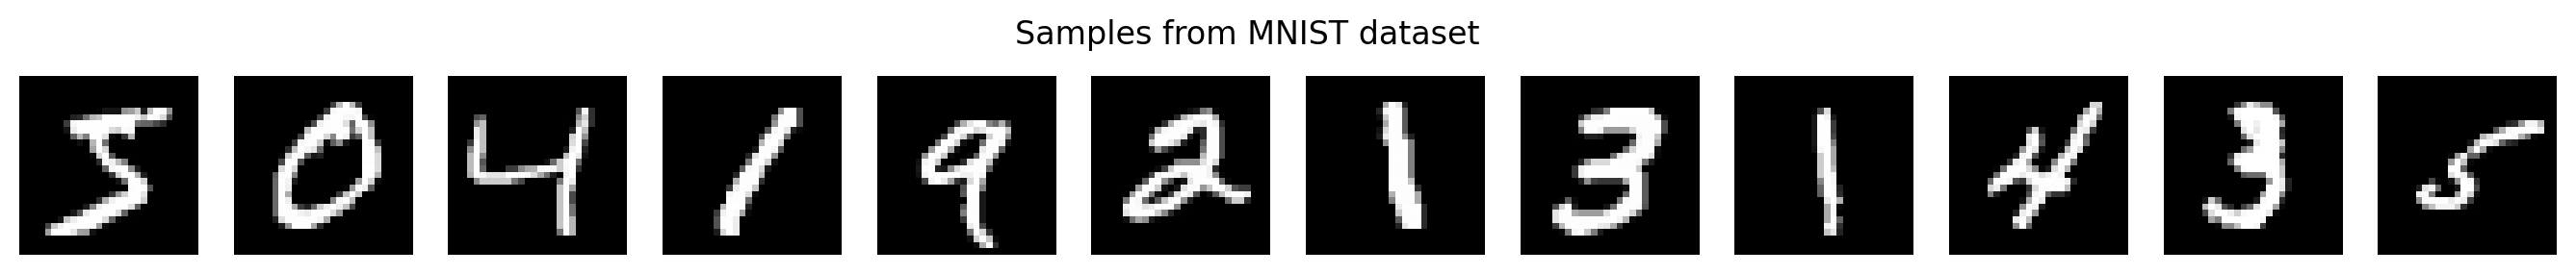

In [3]:
import matplotlib.pyplot as plt
count=12
fig, ax = plt.subplots(1, count,figsize=(17,1.6), dpi=200)
fig.suptitle('Samples from MNIST dataset')
for i in range(count):
    ax[i].imshow(X[i],cmap='Greys_r')
    ax[i].axis('off')

Nyní je cílem tyto snímky klasifikovat, tj. udělat takovou neuronovou síť, která by dokázala vyhodnocovat snímky, se kterými se před tím nikdy nesetkala. 

In [4]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout,AlphaDropout
from keras.layers import Convolution2D,MaxPooling2D,Flatten
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


Neuronové sítě lze v kerasu vytvořit dvěma způsoby. V prvním z nich se využívá třída `keras.models.Sequential`, pomocí které lze jednoduše vytvářet lineární sítě, což jsou takové sítě, kde jde výstup každé vrstvy na vstup následující vrstvy. 

Druhým způsobem lze sítě vytvářet libovolným mícháním výstupů jednotlivých vrstev.

<img src="img/4.svg" style="width: 100%">


## Sequential

In [5]:
classifier = Sequential()

Pomocí této třídy lze jednoduše přidávat další vrstvy pomocí funkce `keras.models.Sequential.add`. Na výběr jsou potom vrstvy např. `keras.layers.Convolution1D`, `keras.layers.Convolution2D`, `keras.layers.MaxPooling2D`, `keras.layers.Flatten`, `keras.layers.Dense`, `keras.layers.BatchNormalization` a další.

Vstupem jsou obrázky, a proto je na místě nejprve využít konvoluční vrstvu. Problém při jejím nepoužití ilustruje následující obrázek:

<img src="img/3.svg" style="width: 50%">

In [6]:
classifier.add(Convolution2D(32, (3, 3),input_shape = [28, 28,1], activation = 'relu', 
                             kernel_regularizer=regularizers.l2(0.001)))

Tímto je do sítě přidána vrstva o `32` neuronech, konvolučním tenzoru o rozměru `(3,3,z)`, vstupním tenzoru velikosti `(28,28,1)`, aktivační funkci `relu` a L2 regularizaci o velikosti `0.001`.

<img src="img/2.svg" style="width: 50%">

Dále na řadu přichází poolingová vrstva.

In [7]:
classifier.add(MaxPooling2D(pool_size = (2, 2)))

Tato vrstva má za úkol redukci dat. Vždy vybere matici o rozměru `(2,2)` a zachová z ní jen nejvyšší hodnotu.

První vrstva zmenšila obrázek na rozměry `(26,26,32)`, druhá z něho udělala `(13,13,32)`. Proces je možno opakovat, dokud nejsou první 2 rozměry výstupu dostatečně nízké. V dalším opakování těchto dvou vrstev je získán výstup o rozměru `(11,11,z')` a `(6,6,z')`, dále pak `(4,4,z")` a `(2,2,z")`. Hodnoty `z'` a `z"` jsou přímo rovny počtu použitých neuronů, jelikož z každého konvolučního neuronu vznikne jedna vrstva výstupního tenzoru.

Dále již není potřeba uvádět velikost vstupního tenzoru, jelikož si ho knihovna `keras` doplní sama podle předešlé vrstvy.

In [8]:
classifier.add(Convolution2D(64, (3, 3), activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

In [9]:
classifier.add(Convolution2D(128, (3, 3), activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

Nyní přichází na řadu _flattening_, který výsledný tenzor vektorizuje. Tato funkce spolu s poolingem neobsahuje žádné trénovatelné parametry.

In [10]:
classifier.add(Flatten())

Poté, co je tenzor vektorizován, mohou se na výsledný vektor aplikovat vrstevnaté sítě (_Dense Neural Networks_). 

<img src="img/1.svg" style="width: 30%">

In [11]:
classifier.add(Dense(units=128, kernel_initializer='he_uniform',bias_initializer='zeros', 
                     activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))

In [12]:
classifier.add(Dense(units=64, kernel_initializer='he_uniform',bias_initializer='zeros', 
                     activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))

Poslední vrstvou je již samotný klasifikátor. Výstupem celé sítě nebude číslo, které je obsaženo na fotografii, ale rozložení pravděpodobnosti pro jednotlivá čísla. Z tohoto důvodu je třeba 10 výstupních neuronů.

In [13]:
classifier.add(Dense(10, activation='softmax'))

Nyní proběhne kompilace sítě, u které se zadávají metody, pomocí kterých je možné síť trénovat.

In [14]:
classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Síť je možno jednoduše vizualizovat, aby byly přehledně vidět všechny vrstvy.

In [15]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)              

## Trénování sítě

Data jsou nyní v rozměru `(60000,28,28)`. Jako vstupní vrstva je však tenzor o rozměru `(28,28,1)`. Z tohoto důvodu je neprve potřeba zvýšit rozměr obrázku o 1.

In [16]:
X=X.reshape((60000,28,28,1)) 

Y je naproti tomu nutné převést na tzv. _dummy variable_.

In [17]:
Y

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [18]:
Y=pd.get_dummies(Y)

In [19]:
Y.head(4)

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0


Samotné trénování pak provádí funkce `keras.models.Sequential.fit`.

In [20]:
history=classifier.fit(x=X,y=Y,batch_size=128,validation_split=0.2,epochs=32)

Train on 48000 samples, validate on 12000 samples
Epoch 1/32
48000/48000 [==============================] - 11s 232us/step - loss: 1.2016 - accuracy: 0.8732 - val_loss: 0.4471 - val_accuracy: 0.9448
Epoch 2/32
48000/48000 [==============================] - 11s 220us/step - loss: 0.3300 - accuracy: 0.9665 - val_loss: 0.3007 - val_accuracy: 0.9650
Epoch 3/32
48000/48000 [==============================] - 10s 215us/step - loss: 0.2317 - accuracy: 0.9766 - val_loss: 0.2637 - val_accuracy: 0.9613
Epoch 4/32
48000/48000 [==============================] - 10s 214us/step - loss: 0.1786 - accuracy: 0.9809 - val_loss: 0.1831 - val_accuracy: 0.9779
Epoch 5/32
48000/48000 [==============================] - 10s 216us/step - loss: 0.1467 - accuracy: 0.9831 - val_loss: 0.1462 - val_accuracy: 0.9812
Epoch 6/32
48000/48000 [==============================] - 10s 215us/step - loss: 0.1265 - accuracy: 0.9848 - val_loss: 0.1289 - val_accuracy: 0.9837
Epoch 7/32
48000/48000 [==============================] 

## Vizualizace trénování

Všechny informace o trénování sítě jsou nyní uloženy do proměnné `history`. V tomto formátu se dají jednoduše vizualizovat.

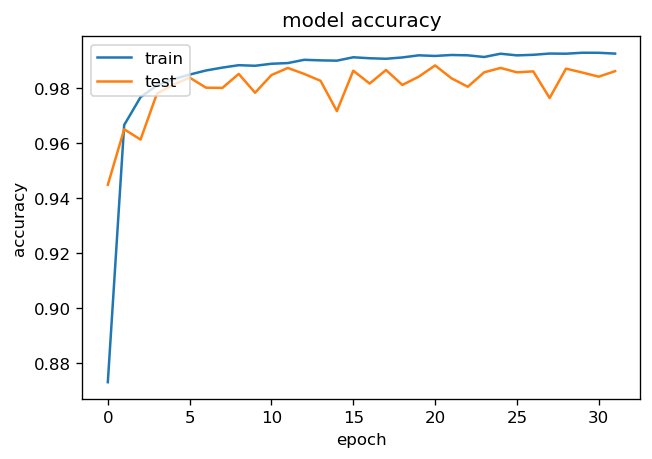

In [21]:
plt.close()
plt.rcParams["figure.dpi"]=120
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.rcParams['figure.figsize'] = 7,3
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

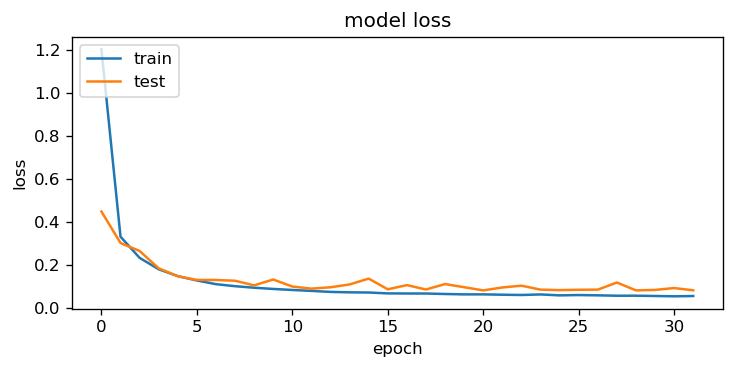

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Podobnou vizualizaci lze najít např. <a href="https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html">zde</a>.